# Bounding Box Approach

Preliminary experiments to design bounding box approach. 

In [1]:
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import box as box

## Simulate Data

In [2]:
def simulate_data(dim, n_samples):
    """ Creates n simulated bounding boxes of a random color on a black grid of size dim.
        Returns the list of bounding box coordinates and the image of the data.
        Inputs:
            dim - dimension at which data is to be simulated, as [cols, rows].
            n_samples - number of bounding boxes to generate on the grid.
        Returns:
            box_list - list of bounding box coordinates, where each entry in the list is
                a set of bounding box coordinates, given as an ndarray in the form 
                [y1, x1, y2, x2].
            img - image of simulated data.
    """
    # get dimensions
    cols, rows = dim
    # create list for storing data [for image display]
    box_list = []
    for n in range(n_samples):
        # create rectangle at random location
        x1 = np.random.randint(cols)
        y1 = np.random.randint(rows)
        height = 2*np.random.randint(48,72) # get height between 4 and 6 feet (1 in = 2 pixel)
        x2 = x1 + height
        y2 = y1 + np.random.randint(12,height)
        # record keypoints in list
        box_list.append([y1,x1,y2,x2])
    # show image
    img = np.zeros((rows,cols,3), np.uint8)
    # for all sets of original points
    for idx, pts in enumerate(box_list):
        # draw rectangle of random color at selected location
        color = (np.random.randint(256),np.random.randint(256),np.random.randint(256))
        cv2.rectangle(img,(pts[0],pts[1]),(pts[2],pts[3]),color,3)
    # show image
    plt.figure()
    plt.imshow(img)
    plt.show()
    # return list of points and image data
    return box_list, img

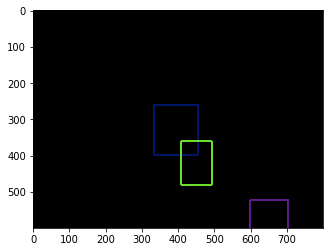

In [3]:
cols = 800
rows = 600
n_samples = 3

sim_box_list, img = simulate_data((cols, rows), n_samples)

## Analyze Bounding Boxes (Simple Average)

In [4]:
sim_box_list

[[334, 260, 455, 398], [599, 522, 703, 654], [408, 360, 493, 482]]

In [5]:
avg_distance, distance_array = box.get_distances_simpleaverage(sim_box_list)
num_pairs, pair_ids = box.count_undistanced(distance_array)

print("Average distance between people (ft):", avg_distance)
print("Number of pairs of people not socially distanced:", num_pairs)
print("Pairwise distance array:\n", distance_array)

Average distance between people (ft): 12.771179375985753
Number of pairs of people not socially distanced: 1
Pairwise distance array:
 [[ 0.         19.04899639  5.6283658 ]
 [19.04899639  0.         13.63617594]
 [ 5.6283658  13.63617594  0.        ]]
